In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2019 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Mesonet Station Plot

Make a surface station plot with Oklahoma Mesonet data.

The station plot itself is pretty straightforward, but there is a bit of code to perform the
data-wrangling.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, StationPlot
from metpy.units import units

# Read in the data and wrangle it

First read in the data. We use pandas because it simplifies a lot of tasks, like dealing
with strings. We'll also convert any blank cells to NaNs, and then drop rows with NaNs
in variables that we want to plot

In [4]:
# Current observations can be downloaded here:
# https://www.mesonet.org/index.php/weather/category/past_data_files
data = pd.read_csv(get_test_data('mesonet_sample.txt', as_file_obj=False), na_values=' ')

# Drop stations with missing values of data we want
data = data.dropna(how='any', subset=['PRES', 'TAIR', 'TDEW', 'WDIR', 'WSPD'])

The mesonet has so many stations that it would clutter the plot if we used them all.
The number of stations plotted will be reduced using `reduce_point_density`.

In [5]:
# Reduce the density of observations so the plot is readable
proj = ccrs.LambertConformal(central_longitude=-98)
point_locs = proj.transform_points(ccrs.PlateCarree(), data['LON'].values, data['LAT'].values)
data = data[mpcalc.reduce_point_density(point_locs, 50 * units.km)]

Now that we have the data we want, we need to perform some conversions:

- First, assign units to the data, as applicable
- Convert cardinal wind direction to degrees
- Get wind components from speed and direction

In [6]:
# Read in the data and assign units as defined by the Mesonet
temperature = data['TAIR'].values * units.degF
dewpoint = data['TDEW'].values * units.degF
pressure = data['PRES'].values * units.hPa
wind_speed = data['WSPD'].values * units.mph
wind_direction = data['WDIR']
latitude = data['LAT']
longitude = data['LON']
station_id = data['STID']

# Take cardinal direction and convert to degrees, then convert to components
wind_direction = mpcalc.parse_angle(list(wind_direction))
u, v = mpcalc.wind_components(wind_speed.to('knots'), wind_direction)

# Create the figure

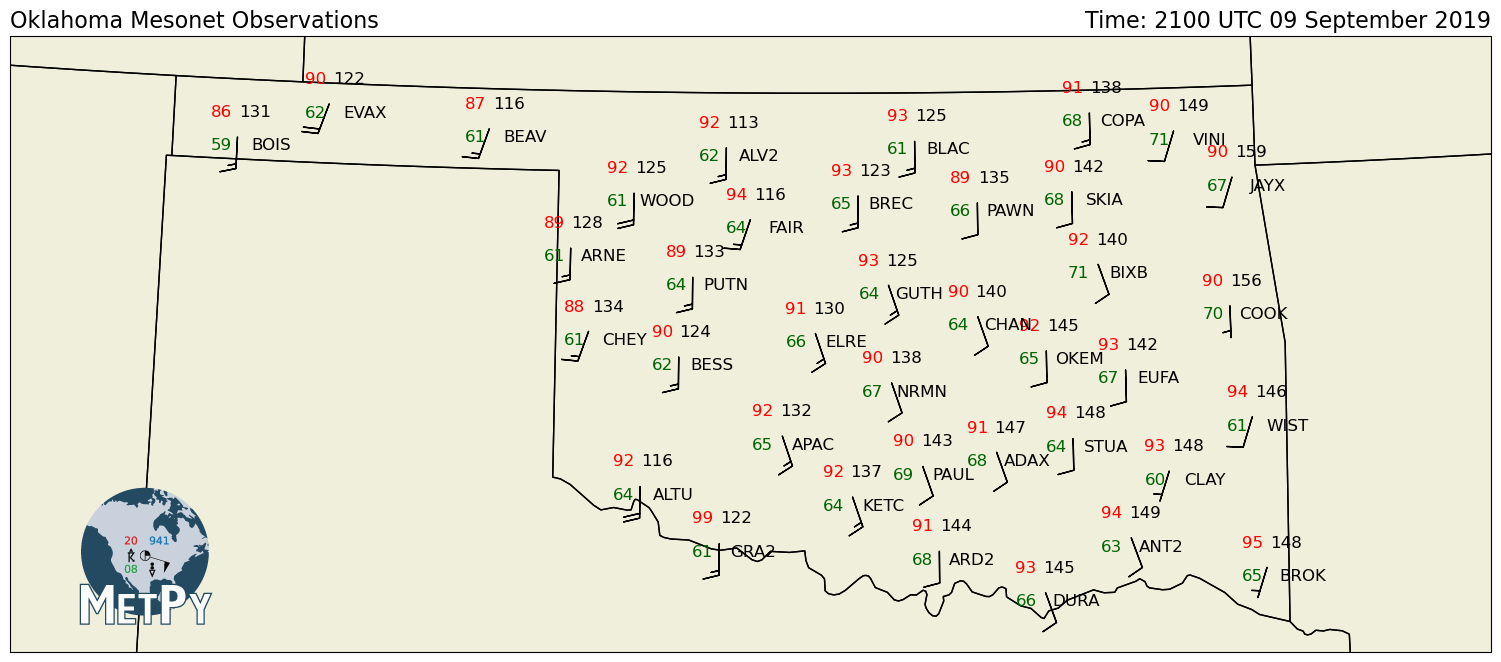

In [7]:
# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 8))
add_metpy_logo(fig, 70, 30, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Set plot bounds
ax.set_extent((-104, -93, 33.4, 37.2))

stationplot = StationPlot(ax, longitude.values, latitude.values, clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', temperature, color='red')
stationplot.plot_parameter('SW', dewpoint, color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', pressure.m, formatter=lambda v: format(10 * v, '.0f')[-3:])

# Add wind barbs
stationplot.plot_barb(u, v)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and -1 in y.
stationplot.plot_text((2, -1), station_id)

# Add title and display figure
plt.title('Oklahoma Mesonet Observations', fontsize=16, loc='left')
plt.title('Time: 2100 UTC 09 September 2019', fontsize=16, loc='right')
plt.show()